In [1]:
from main import *
from useful_functions import *

%matplotlib inline
plt.rcParams['font.size'] = 18

# Setting paths

In [2]:
top_directory = '/media/anleg84/One Touch/Data/Main/'

atlas_path = '/home/anleg84/Documents/Atlas/Mapzebrain/'

In [3]:
atlas = MapzebrainAtlas(atlas_path)

In [4]:
def get_datasets(top_directory, keywords=[], exclude=[]):
    folders = identify_folders(top_directory, ['dpf'])
    datasets = []
    for folder in folders:
        datasets += identify_folders(folder, keywords=keywords, exclude=exclude)
    return datasets

In [5]:
datasets = get_datasets(top_directory, keywords=['920nm'], exclude=[])
datasets

['/media/anleg84/One Touch/Data/Main/20230725-Wholebrain-6dpf/20230725_12_39_26_920nm_6dpf_fish1_wholebrain/',
 '/media/anleg84/One Touch/Data/Main/20230725-Wholebrain-6dpf/20230725_16_19_46_920nm_6dpf_fish2_wholebrain/',
 '/media/anleg84/One Touch/Data/Main/20230725-Wholebrain-6dpf/20230725_17_27_08_920nm_6dpf_fish4_wholebrain/',
 '/media/anleg84/One Touch/Data/Main/20230725-Wholebrain-6dpf/20230725_19_15_44_920nm_6dpf_fish6_wholebrain/',
 '/media/anleg84/One Touch/Data/Main/20230726-Wholebrain-7dpf/20230726_12_43_30_920nm_7dpf_fish1_wholebrain/',
 '/media/anleg84/One Touch/Data/Main/20230726-Wholebrain-7dpf/20230726_14_59_58_920nm_7dpf_fish2_wholebrain/',
 '/media/anleg84/One Touch/Data/Main/20230726-Wholebrain-7dpf/20230726_15_40_59_920nm_7dpf_fish3_wholebrain/',
 '/media/anleg84/One Touch/Data/Main/20230726-Wholebrain-7dpf/20230726_16_13_39_920nm_7dpf_fish4_wholebrain/',
 '/media/anleg84/One Touch/Data/Main/20230726-Wholebrain-7dpf/20230726_17_21_03_920nm_7dpf_fish5_wholebrain/',
 

# Inspecting max intensity projections

In [8]:
projections = []

for ds in tqdm(datasets, file=sys.stdout):
    data = load_data(ds)
    projections.append(np.max(data['average_frames'], axis=0))

100%|███████████████████████████████████████████| 22/22 [02:11<00:00,  5.97s/it]


Double-click figure for enlarged display and better visualization of individual brains.

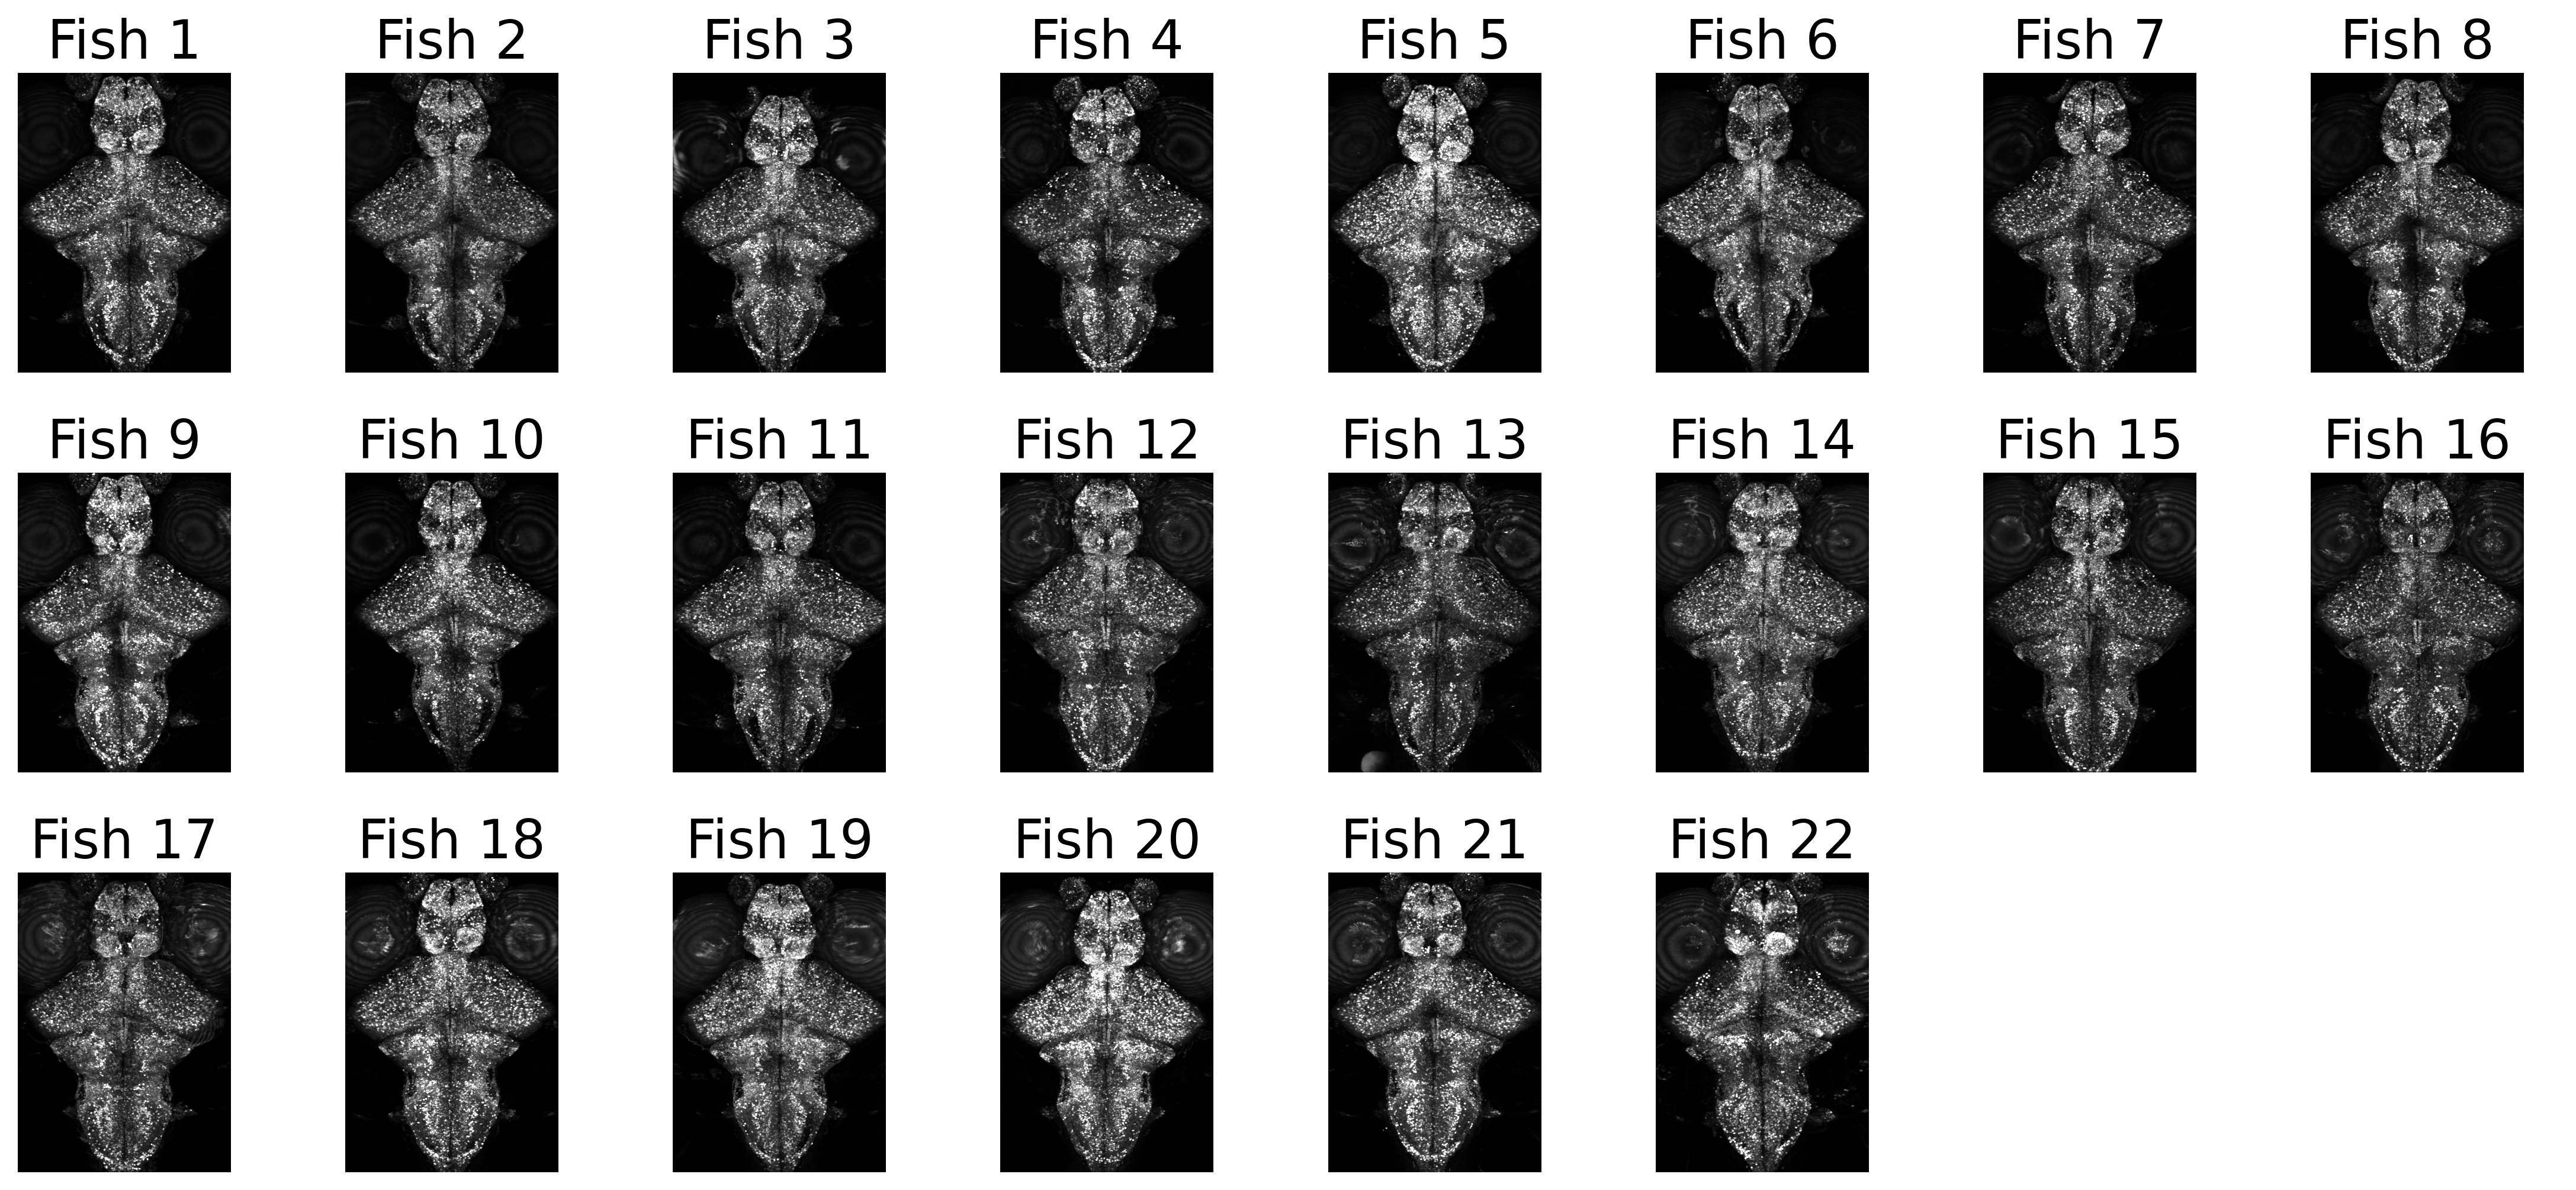

In [21]:
fig, axes = plt.subplots(3, 8, figsize=(15, 7), dpi=300)

for i, p in enumerate(projections):
    ax = axes.flatten()[i]
    ax.imshow(p, cmap='gray', vmax=30000)
    ax.set_title('Fish {}'.format(i + 1))

for i in range(len(axes.flatten())):
    ax = axes.flatten()[i]
    ax.axis('off')
    
plt.tight_layout(pad=1)
plt.show()

# Counting neurons in every region

Finding which regions to exclude.

In [6]:
compute = False
if compute:
    N_neurons = []
    for folder in tqdm(datasets, file=sys.stdout):
        data = load_data(folder)
        N_neurons.append(np.sum(data['region_labels'], axis=0))
    N = np.stack(N_neurons, axis=0)
    np.save('Results/N_neurons_per_region.npy', N)
else:
    N = np.load('Results/N_neurons_per_region.npy')

Exclusion criterion: a brain region must have at least 25 sampled neurons in at least half of the datasets.

In [7]:
excluded = np.concatenate([[10], np.where((np.sum(N >= 25, axis=0) >= len(datasets)/2) == False)[0]])
excluded

array([10, 34, 44, 49, 69])

In [8]:
for e in excluded:
    print(atlas.names[e])

retina
pituitary
caudal_hypothalamus
glossopharyngeal_ganglion
lateral_reticular_nucleus


In [9]:
np.save('Results/excluded_regions.npy', excluded)

# Plotting N neurons

In [10]:
def plot_barchart_regions(ax, data_mean, data_std, labels, color='black', order=False, delta=0.1):
    if order:
        order = np.flip(np.argsort(data_mean))
    else:
        order = np.arange(0, len(labels))
    data_mean, data_std = np.copy(data_mean)[order], np.copy(data_std)[order]
    ax.bar(np.arange(0, len(labels)), data_mean, color=color)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xticks(np.arange(0, len(labels)), np.array(labels)[order], rotation=90, fontsize=12)
    for i in range(len(labels)):
        ax.plot([i, i], [data_mean[i], data_mean[i] + data_std[i]], color='black')
        ax.plot([i - delta, i + delta], [data_mean[i] + data_std[i], data_mean[i] + data_std[i]], color='black')

In [11]:
N = np.load('Results/N_neurons_per_region.npy')

N = np.delete(N, 10, axis=1) # Removing retina from count
labels = np.delete(atlas.acronyms, 10)

mean = np.mean(N, axis=0)
std = np.std(N, axis=0)

In [12]:
print('Average number of neurons per larva (mean +/- std):')
print(np.sum(mean), '+/-', np.std(np.sum(N, axis=1)))

Average number of neurons per larva (mean +/- std):
54464.50000000001 +/- 5086.475550194582


In [13]:
order = np.flip(np.argsort(mean))

In [14]:
excluded_regions = []
for r in order:
    if r + 1 in excluded[1:]:
        excluded_regions.append(True)
    else:
        excluded_regions.append(False)
excluded_regions = np.array(excluded_regions)

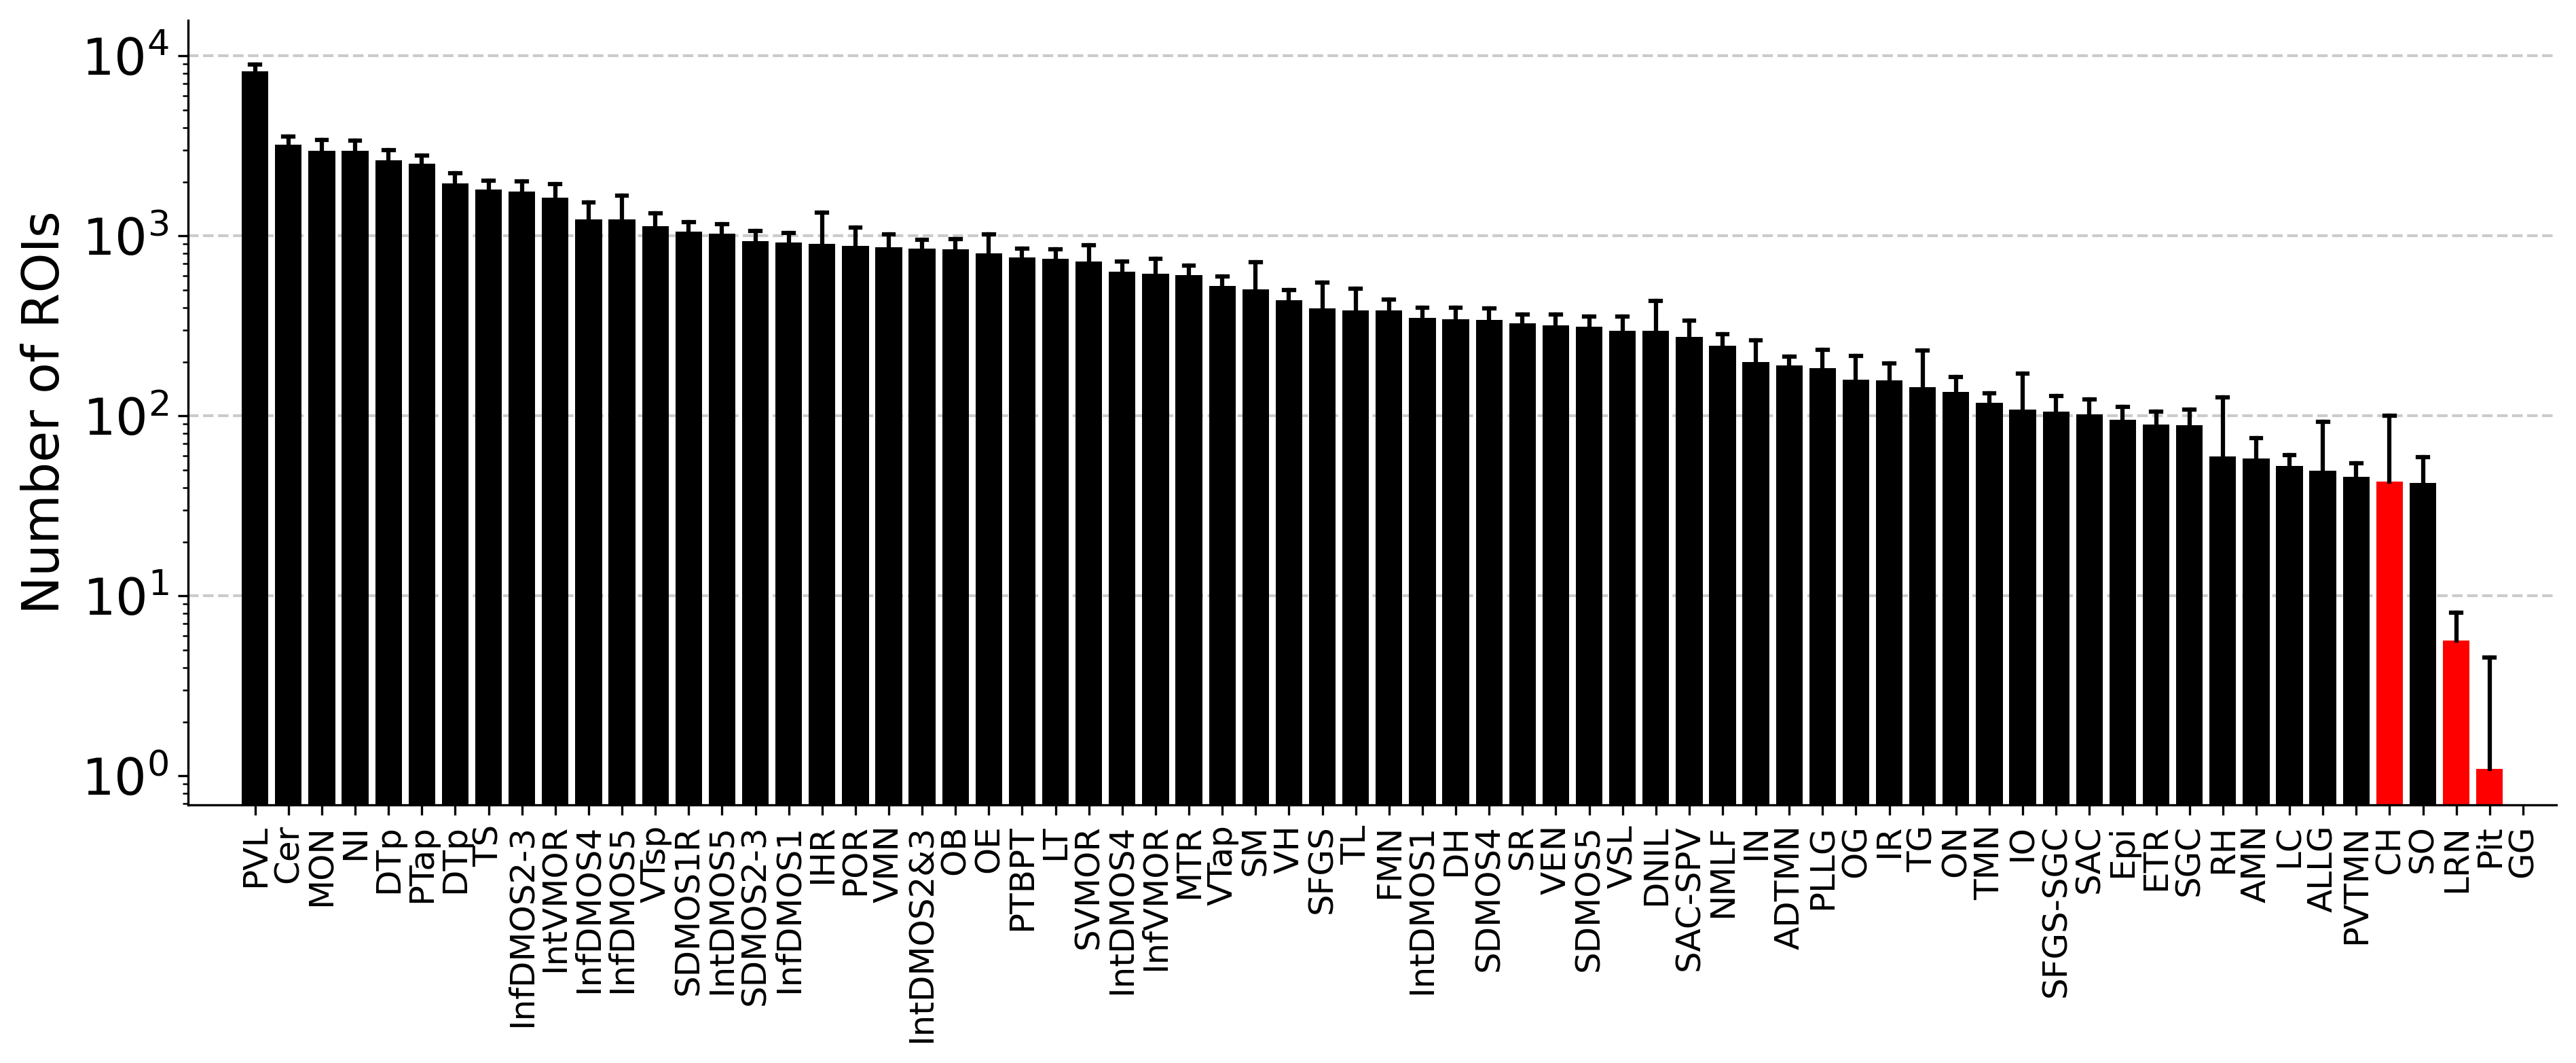

In [15]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=300)

x = np.where(excluded_regions == False)[0]
ax.bar(x, mean[order][excluded_regions == False], color='black')

x = np.where(excluded_regions)[0]
ax.bar(x, mean[order][excluded_regions], color='red')

delta = 0.15
data_mean, data_std = np.copy(mean)[order], np.copy(std)[order]
for i in range(len(labels)):
        ax.plot([i, i], [data_mean[i], data_mean[i] + data_std[i]], color='black')
        ax.plot([i - delta, i + delta], [data_mean[i] + data_std[i], data_mean[i] + data_std[i]], color='black')
ax.set_xticks(np.arange(0, len(labels)), np.array(labels)[order], rotation=90, fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
plt.yscale('log')

for y in [1e4, 1e3, 1e2, 1e1]:
    ax.plot([-2, 69], [y, y], color=[0.6, 0.6, 0.6], linewidth=1, linestyle='--', alpha=0.5, zorder=-10)

ax.set_ylabel('Number of ROIs')
ax.set_xlim([-2, 69])
plt.show()

# Generating atlas region projections

For visualization purposes in certain figures.

In [16]:
masks_top = np.zeros((70, 974, 597))
for i in tqdm(range(70), file=sys.stdout):
    if i != 10:
        mask = atlas.getRegionMask(i, orientation='vertical')
        masks_top[i] = np.mean(mask, axis=0)

100%|███████████████████████████████████████████| 70/70 [01:02<00:00,  1.13it/s]


In [35]:
masks_side = np.zeros((70, 359, 974))
for i in tqdm(range(70), file=sys.stdout):
    if i != 10:
        mask = atlas.getRegionMask(i, orientation='vertical')
        masks_side[i] = np.mean(mask, axis=2)

100%|███████████████████████████████████████████| 70/70 [00:42<00:00,  1.64it/s]


In [36]:
N_intersects = np.sum(masks_top > 0, axis=0)
projection_top = np.mean(masks_top, axis=0) / (N_intersects + 1)

N_intersects = np.sum(masks_side > 0, axis=0)
projection_side = np.mean(masks_side, axis=0) / (N_intersects + 1)

(-0.5, 973.5, 358.5, -0.5)

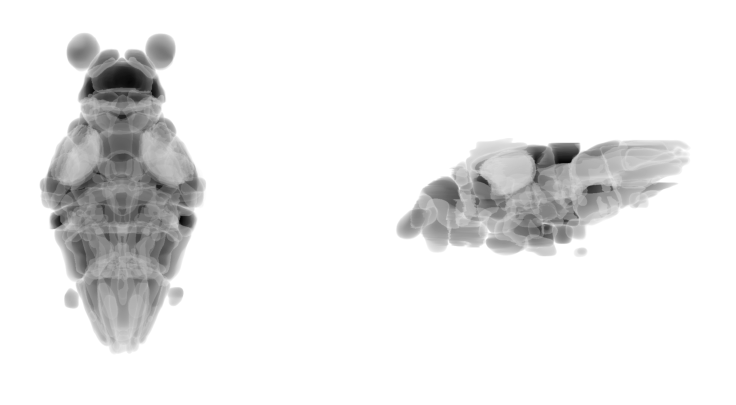

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(projection_top, cmap='binary')
ax[0].axis('off')
ax[1].imshow(projection_side, cmap='binary')
ax[1].axis('off')

In [38]:
np.save('Results/projection_regions_top.npy', projection_top)
np.save('Results/projection_regions_side.npy', projection_side)

# Removing baselines from fluorescence signals and computing regional activity

Computing $\Delta F/F_0$ normalization for all neuronal time series, and saving these normalized time series in a separate numpy array in each folder. Also computing regional fluorescence signals while we're at it.

Baselines are identified from signals using a gaussian-filtered minimum filter with a large temporal window (300 time steps, or roughly 5 minutes of recording) in order to preserve most of the original signal, while still removing unwanted slow drifts induced by photobleaching of the fluorophore. Going for a conservative approach here.

In [39]:
for folder in tqdm(datasets, file=sys.stdout):
    
    data = load_data(folder)
    data['timeseries'][:, 0] = data['timeseries'][:, 1]
    dff = compute_dff_using_minfilter(data['timeseries'],
                                      window=300,
                                      sigma1=3,
                                      sigma2=60)
    np.save(folder + 'dff.npy', dff)

    region_series = np.zeros((70, dff.shape[1]))
    for i in range(70):
        labels = data['region_labels'][:, i]
        if np.any(labels):
            region_series[i] = np.mean(dff[labels != 0], axis=0)
    region_series = np.stack(region_series, axis=0)

    np.save(folder + 'region_series_dff.npy', region_series)

100%|███████████████████████████████████████████| 22/22 [10:56<00:00, 29.84s/it]


# Computing functional networks

Applying a gaussian filter ($\sigma=2$s) on regional calcium time series before computing pearson correlations. Taking only the first 600 time steps (10 minutes of spontaneous activity) to exclude visual stimulation period.

In [41]:
sigma = 2

rseries = []
for ds in datasets:
    rseries.append(np.load(ds + 'region_series_dff.npy')[:, :600]) # Excluding visual stimulation
    for i in range(rseries[-1].shape[0]):
        rseries[-1][i] = gaussian_filter1d(rseries[-1][i], sigma)

Using `nanmean` here because some larvae have unsampled regions, which result in `NaN` correlation coefficients in individual FC matrices. This means that each functional pathway is averaged over a slightly different number of larvae/experiments, but due to previous exclusion criteria, the minimal number of samples is 11 (half the dataset of 22 larvae), which we deem an adequate statistical power for each region.

In [43]:
matrices = []
for ts in rseries:
    matrix = compute_correlation_matrix(ts)
    # matrix[np.isnan(matrix)] = 0
    matrices.append(matrix)
matrices = np.stack(matrices, axis=0)

matrices = np.delete(matrices, excluded, axis=1)
matrices = np.delete(matrices, excluded, axis=2)

FC = np.nanmean(matrices, axis=0)

In [48]:
np.save('Results/FC_matrix.npy', FC)

# 